# Simplified detection of urban types

Example adapted from the [SDSC 2021 Workshop](https://github.com/martinfleis/sdsc21-workshop) led by Martin Fleischmann. You can see the recording of the workshop on [YouTube](https://www.youtube.com/watch?v=itUX56Ks1UE).

This example illustrates the potential of morphometrics captured by `momepy` in capturing the structure of cities. We will pick a town, fetch its data from the OpenStreetMap, and analyse it to detect individual types of urban structure within it.

This method is only illustrative and is based on the more extensive one published by Fleischmann et al. (2021) available from [https://github.com/martinfleis/numerical-taxonomy-paper](https://github.com/martinfleis/numerical-taxonomy-paper).

> Fleischmann M, Feliciotti A, Romice O and Porta S (2021) Methodological Foundation of a Numerical Taxonomy of Urban Form. Environment and Planning B: Urban Analytics and City Science, doi: 10.1177/23998083211059835

It depends on the following packages:

```
- momepy
- osmnx
- clustergram
- bokeh
- scikit-learn
- geopy
- ipywidgets
```


In [1]:
import warnings

import geopandas
import libpysal
import momepy
import osmnx
import pandas

from clustergram import Clustergram

import matplotlib.pyplot as plt
from bokeh.io import output_notebook
from bokeh.plotting import show

output_notebook()

Loading BokehJS ...

Pick a place, ideally a town with a good coverage in OpenStreetMap and its local CRS.

In [2]:
place = 'Znojmo, Czechia'
local_crs = 5514

We can interactively explore the place we just selected.

In [3]:
geopandas.tools.geocode(place).explore()

## Input data

We can use ``OSMnx`` to quickly download data from OpenStreetMap. If you intend to download larger areas, we recommend using ``pyrosm`` instead.

### Buildings

In [4]:
buildings = osmnx.geometries.geometries_from_place(place, tags={'building':True})
buildings.head()

amenity  \
element_type osmid                          
node         3749294087  place_of_worship   
             4756492121  place_of_worship   
             6898265457               NaN   
way          50293678    place_of_worship   
             50293682    place_of_worship   

                                                                  geometry  \
element_type osmid                                                           
node         3749294087                          POINT (16.04696 48.85305)   
             4756492121                          POINT (16.02817 48.83953)   
             6898265457                          POINT (16.01186 48.85677)   
way          50293678    POLYGON ((16.03814 48.85812, 16.03814 48.85814...   
             50293682    POLYGON ((16.03830 48.85657, 16.03833 48.85659...   

                        tourism brand brand:wikidata brand:wikipedia  \
element_type osmid                                                     
node         3749294087     NaN   NaN            NaN             NaN   
             4756492121     NaN   NaN            NaN             NaN   
             6898265457     NaN   NaN            NaN             NaN   
way          50293678       NaN   NaN            NaN             NaN   
             50293682       NaN   NaN            NaN             NaN   

                                   name operator operator:wikidata  \
element_type osmid                                                   
node         3749294087             NaN      NaN               NaN   
             4756492121             NaN      NaN               NaN   
             6898265457             NaN      NaN               NaN   
way          50293678       sv. Antonín      NaN               NaN   
             50293682    Eliášova kaple      NaN               NaN   

                        operator:wikipedia  ... voltage source_1 pillbox  \
element_type osmid                          ...                            
node         3749294087                NaN  ...     NaN      NaN     NaN   
             4756492121                NaN  ...     NaN      NaN     NaN   
             6898265457                NaN  ...     NaN      NaN     NaN   
way          50293678                  NaN  ...     NaN      NaN     NaN   
             50293682                  NaN  ...     NaN      NaN     NaN   

                        name:signed building:part  ref min_height ways type  \
element_type osmid                                                            
node         3749294087         NaN           NaN  NaN        NaN  NaN  NaN   
             4756492121         NaN           NaN  NaN        NaN  NaN  NaN   
             6898265457         NaN           NaN  NaN        NaN  NaN  NaN   
way          50293678           NaN           NaN  NaN        NaN  NaN  NaN   
             50293682           NaN           NaN  NaN        NaN  NaN  NaN   

                        emergency  
element_type osmid                 
node         3749294087       NaN  
             4756492121       NaN  
             6898265457       NaN  
way          50293678         NaN  
             50293682         NaN  

[5 rows x 91 columns]

The OSM input may need a bit of cleaning to ensure only proper polygons are kept.

In [5]:
buildings.geom_type.value_counts()

Polygon    12127
Point          3
dtype: int64

In [6]:
buildings = buildings[buildings.geom_type == "Polygon"].reset_index(drop=True)

And we should re-project the data from WGS84 to the local projection in meters (momepy default values assume meters not feet or degrees). We will also drop unnecessary columns.

In [7]:
buildings = buildings[["geometry"]].to_crs(local_crs)

Finally, we can assign unique ID to each row.

In [8]:
buildings["uID"] = range(len(buildings))
buildings.head()

,geometry,uID
0,"POLYGON ((-643743.474 -1193358.749, -643743.30...",0
1,"POLYGON ((-643751.446 -1193530.633, -643749.37...",1
2,"POLYGON ((-643281.601 -1193130.831, -643283.76...",2
3,"POLYGON ((-643381.904 -1193174.697, -643388.48...",3
4,"POLYGON ((-643370.450 -1193130.215, -643398.26...",4


### Streets

Similar operations are done with streets.

In [9]:
osm_graph = osmnx.graph_from_place(place, network_type='drive')
osm_graph = osmnx.projection.project_graph(osm_graph, to_crs=local_crs)
streets = osmnx.graph_to_gdfs(
    osm_graph, 
    nodes=False,
    edges=True,
    node_geometry=False,
    fill_edge_geometry=True
)

In [10]:
streets.head()

osmid  ref        name      highway  oneway  \
u         v          key                                                   
74103628  639231391  0    33733060  361  Přímětická    secondary   False   
          3775990798 0    33733060  361  Přímětická    secondary   False   
639231391 74103628   0    33733060  361  Přímětická    secondary   False   
          74142638   0    33733060  361  Přímětická    secondary   False   
          639231314  0    50313241  NaN  Mičurinova  residential    True   

                           length  \
u         v          key            
74103628  639231391  0     24.574   
          3775990798 0     60.354   
639231391 74103628   0     24.574   
          74142638   0     54.260   
          639231314  0    101.376   

                                                                   geometry  \
u         v          key                                                      
74103628  639231391  0    LINESTRING (-643239.057 -1192850.232, -643229....   
          3775990798 0    LINESTRING (-643239.057 -1192850.232, -643241....   
639231391 74103628   0    LINESTRING (-643229.639 -1192872.949, -643239....   
          74142638   0    LINESTRING (-643229.639 -1192872.949, -643219....   
          639231314  0    LINESTRING (-643229.639 -1192872.949, -643233....   

                         maxspeed lanes bridge junction width tunnel access  
u         v          key                                                     
74103628  639231391  0        NaN   NaN    NaN      NaN   NaN    NaN    NaN  
          3775990798 0        NaN   NaN    NaN      NaN   NaN    NaN    NaN  
639231391 74103628   0        NaN   NaN    NaN      NaN   NaN    NaN    NaN  
          74142638   0        NaN   NaN    NaN      NaN   NaN    NaN    NaN  
          639231314  0        NaN   NaN    NaN      NaN   NaN    NaN    NaN

We can also do some preprocessing using momepy to ensure we have proper network topology.

In [11]:
streets = momepy.remove_false_nodes(streets)
streets = streets[["geometry"]]
streets["nID"] = range(len(streets))

In [12]:
streets.head()

,geometry,nID
0,"LINESTRING (-643239.057 -1192850.232, -643229....",0
1,"LINESTRING (-643239.057 -1192850.232, -643241....",1
2,"LINESTRING (-643229.639 -1192872.949, -643239....",2
3,"LINESTRING (-643229.639 -1192872.949, -643219....",3
4,"LINESTRING (-643229.639 -1192872.949, -643233....",4


## Generated data

### Tessellation

Given building footprints:

![blg](http://docs.momepy.org/en/stable/_images/user_guide_elements_tessellation_3_0.png)

We can generate a spatial unit using morphological tessellation:

![tess](http://docs.momepy.org/en/stable/_images/user_guide_elements_tessellation_14_0.png)

In [13]:
limit = momepy.buffered_limit(buildings, 100)

tessellation = momepy.Tessellation(buildings, "uID", limit, verbose=False, segment=1)
tessellation = tessellation.tessellation

/Users/martin/mambaforge/envs/stable/lib/python3.9/site-packages/momepy/elements.py:383: UserWarning: Tessellation does not fully match buildings. 23 element(s) collapsed during generation - unique_id: {11652, 11653, 10630, 11660, 4237, 4245, 4248, 3999, 11431, 11432, 4009, 4275, 4278, 4282, 4283, 4287, 4288, 9177, 10851, 10852, 8682, 4089, 9212}
  warnings.warn(
/Users/martin/mambaforge/envs/stable/lib/python3.9/site-packages/momepy/elements.py:394: UserWarning: Tessellation contains MultiPolygon elements. Initial objects should be edited. unique_id of affected elements: [10034, 9864, 4227, 3263, 3196, 11965, 3209, 11168]
  warnings.warn(


### Link streets

Link unique IDs of streets to buildings and tessellation cells based on the nearest neighbor join.

In [14]:
buildings = buildings.sjoin_nearest(streets, max_distance=1000, how="left")
buildings.head()

,geometry,uID,index_right,nID
0,"POLYGON ((-643743.474 -1193358.749, -643743.30...",0,1048.0,1048.0
0,"POLYGON ((-643743.474 -1193358.749, -643743.30...",0,1047.0,1047.0
1,"POLYGON ((-643751.446 -1193530.633, -643749.37...",1,1457.0,1457.0
2,"POLYGON ((-643281.601 -1193130.831, -643283.76...",2,243.0,243.0
2,"POLYGON ((-643281.601 -1193130.831, -643283.76...",2,886.0,886.0


Clean duplicates and attach the network ID to the tessellation as well.

In [15]:
buildings = buildings.drop_duplicates("uID").drop(columns="index_right")
tessellation = tessellation.merge(buildings[['uID', 'nID']], on='uID', how='left')

## Measure

Measure individual morphometric characters. For details see the User Guide and the API reference.

### Dimensions

In [16]:
buildings["area"] = buildings.area
tessellation["area"] = tessellation.area
streets["length"] = streets.length

### Shape

In [17]:
buildings['eri'] = momepy.EquivalentRectangularIndex(buildings).series
buildings['elongation'] = momepy.Elongation(buildings).series
tessellation['convexity'] = momepy.Convexity(tessellation).series
streets["linearity"] = momepy.Linearity(streets).series

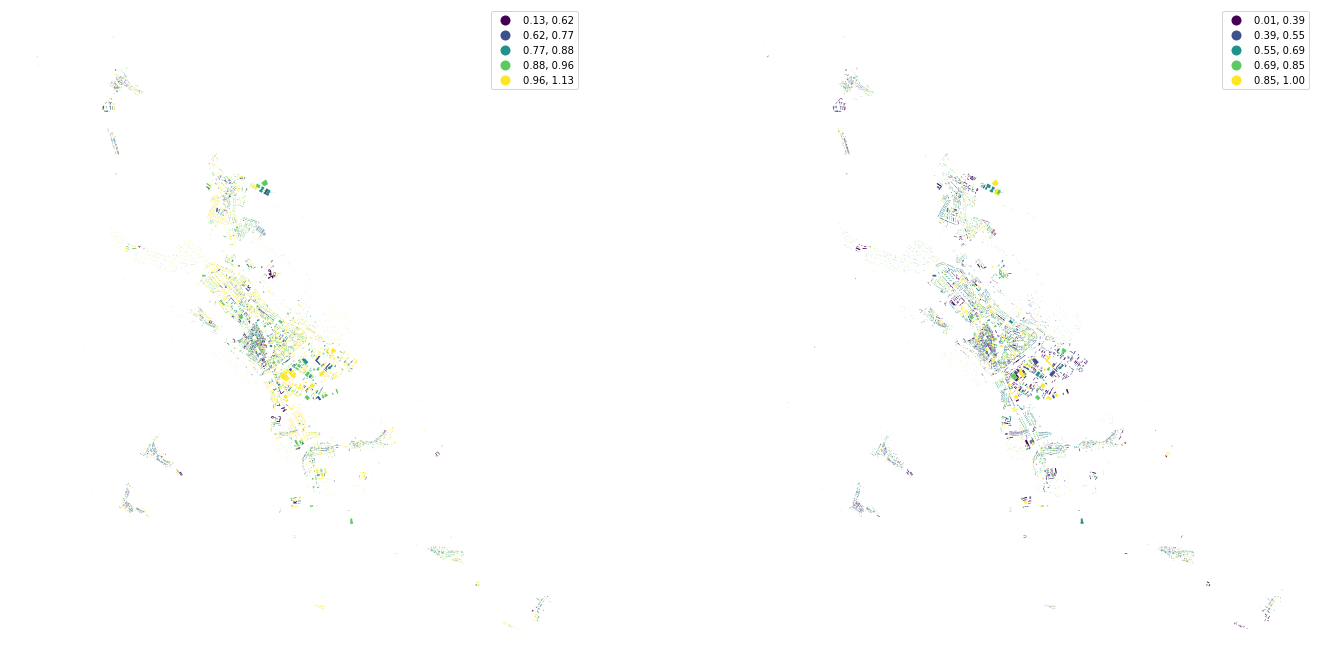

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

buildings.plot("eri", ax=ax[0], scheme="natural_breaks", legend=True)
buildings.plot("elongation", ax=ax[1], scheme="natural_breaks", legend=True)

ax[0].set_axis_off()
ax[1].set_axis_off()

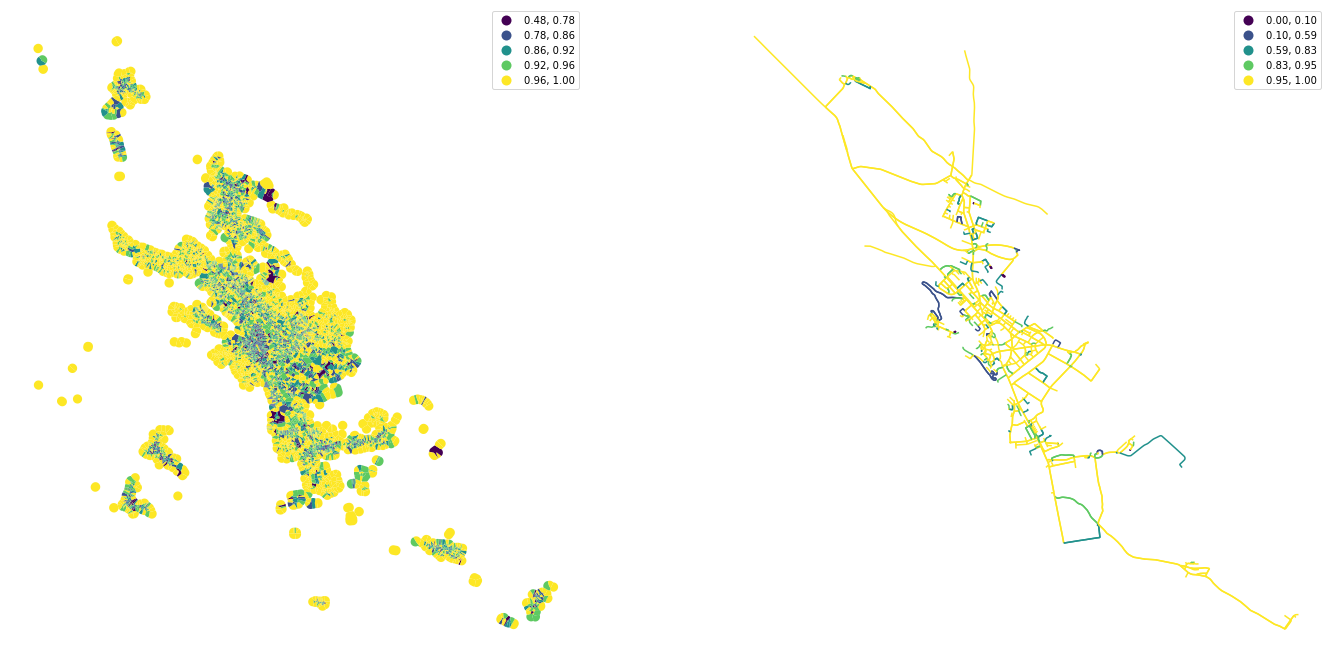

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

tessellation.plot("convexity", ax=ax[0], scheme="natural_breaks", legend=True)
streets.plot("linearity", ax=ax[1], scheme="natural_breaks", legend=True)

ax[0].set_axis_off()
ax[1].set_axis_off()

### Spatial distribution

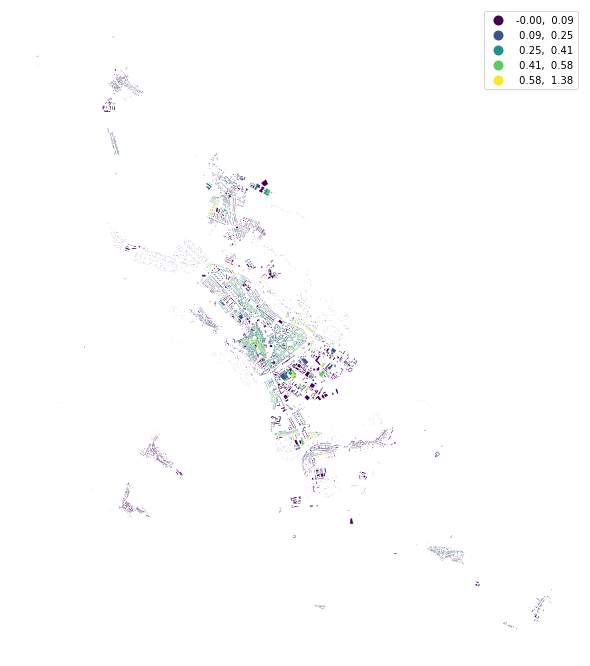

In [20]:
buildings["shared_walls"] = momepy.SharedWallsRatio(buildings).series
buildings.plot("shared_walls", figsize=(12, 12), scheme="natural_breaks", legend=True).set_axis_off()

Generate spatial weights matrix using `libpysal`.

In [21]:
queen_1 = libpysal.weights.contiguity.Queen.from_dataframe(tessellation, ids="uID", silence_warnings=True)

/Users/martin/mambaforge/envs/stable/lib/python3.9/site-packages/libpysal/weights/_contW_lists.py:29: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  return list(it.chain(*(list(zip(*shape.coords.xy)) for shape in shape)))
/Users/martin/mambaforge/envs/stable/lib/python3.9/site-packages/libpysal/weights/_contW_lists.py:31: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  return list(it.chain(*(_get_boundary_points(part.boundary) for part in shape)))


In [22]:
tessellation["neighbors"] = momepy.Neighbors(tessellation, queen_1, "uID", weighted=True, verbose=False).series
tessellation["covered_area"] = momepy.CoveredArea(tessellation, queen_1, "uID", verbose=False).series

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    buildings["neighbor_distance"] = momepy.NeighborDistance(buildings, queen_1, "uID", verbose=False).series

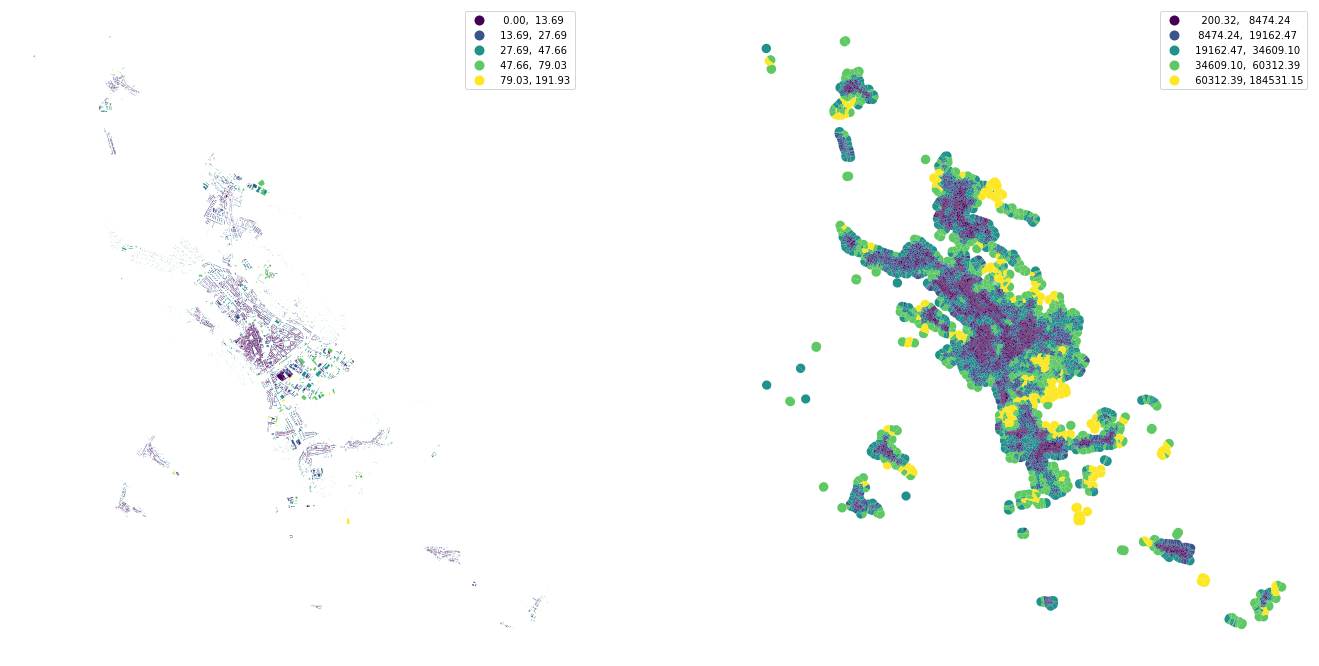

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

buildings.plot("neighbor_distance", ax=ax[0], scheme="natural_breaks", legend=True)
tessellation.plot("covered_area", ax=ax[1], scheme="natural_breaks", legend=True)

ax[0].set_axis_off()
ax[1].set_axis_off()

In [24]:
queen_3 = momepy.sw_high(k=3, weights=queen_1)
buildings_q1 = libpysal.weights.contiguity.Queen.from_dataframe(buildings, silence_warnings=True)

buildings['interbuilding_distance'] = momepy.MeanInterbuildingDistance(buildings, queen_1, 'uID', 3, verbose=False).series
buildings['adjacency'] = momepy.BuildingAdjacency(buildings, queen_3, 'uID', buildings_q1, verbose=False).series

/Users/martin/mambaforge/envs/stable/lib/python3.9/site-packages/libpysal/weights/_contW_lists.py:29: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  return list(it.chain(*(list(zip(*shape.coords.xy)) for shape in shape)))


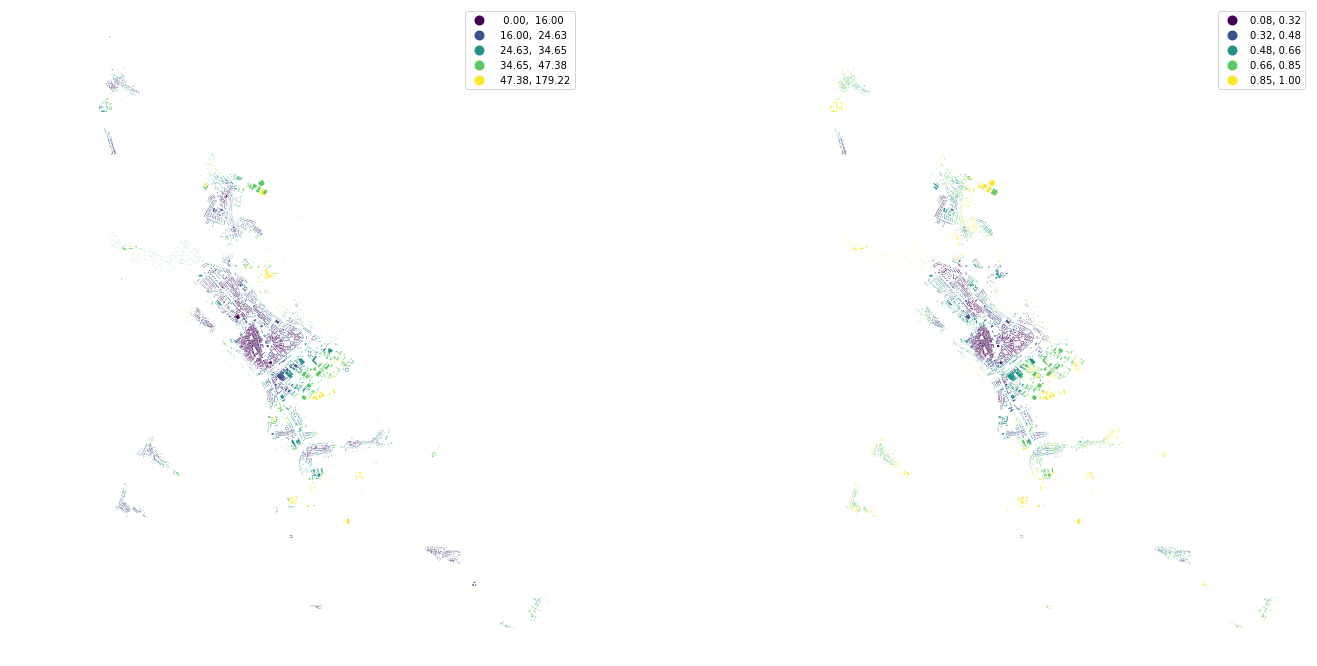

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

buildings.plot("interbuilding_distance", ax=ax[0], scheme="natural_breaks", legend=True)
buildings.plot("adjacency", ax=ax[1], scheme="natural_breaks", legend=True)

ax[0].set_axis_off()
ax[1].set_axis_off()

In [26]:
profile = momepy.StreetProfile(streets, buildings)
streets["width"] = profile.w
streets["width_deviation"] = profile.wd
streets["openness"] = profile.o

/Users/martin/mambaforge/envs/stable/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/martin/mambaforge/envs/stable/lib/python3.9/site-packages/momepy/dimension.py:641: RuntimeWarning: invalid value encountered in long_scalars
  openness.append(np.isnan(s).sum() / (f).sum())


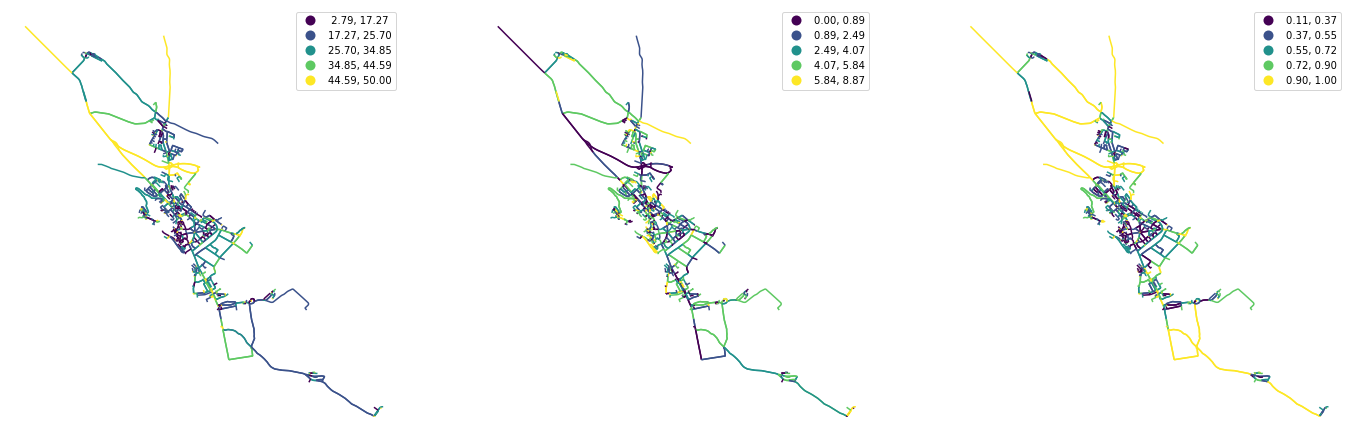

In [27]:
fig, ax = plt.subplots(1, 3, figsize=(24, 12))

streets.plot("width", ax=ax[0], scheme="natural_breaks", legend=True)
streets.plot("width_deviation", ax=ax[1], scheme="natural_breaks", legend=True)
streets.plot("openness", ax=ax[2], scheme="natural_breaks", legend=True)

ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()

### Intensity

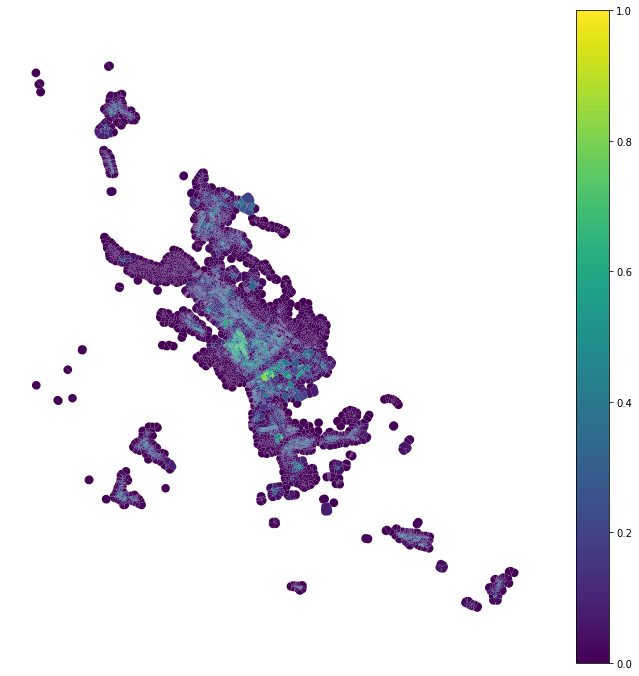

In [28]:
tessellation['car'] = momepy.AreaRatio(tessellation, buildings, 'area', 'area', 'uID').series
tessellation.plot("car", figsize=(12, 12), vmin=0, vmax=1, legend=True).set_axis_off()

### Connectivity

In [29]:
graph = momepy.gdf_to_nx(streets)
graph = momepy.node_degree(graph)
graph = momepy.closeness_centrality(graph, radius=400, distance="mm_len")
graph = momepy.meshedness(graph, radius=400, distance="mm_len")
nodes, streets = momepy.nx_to_gdf(graph)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 756/756 [00:00<00:00, 2234.40it/s]


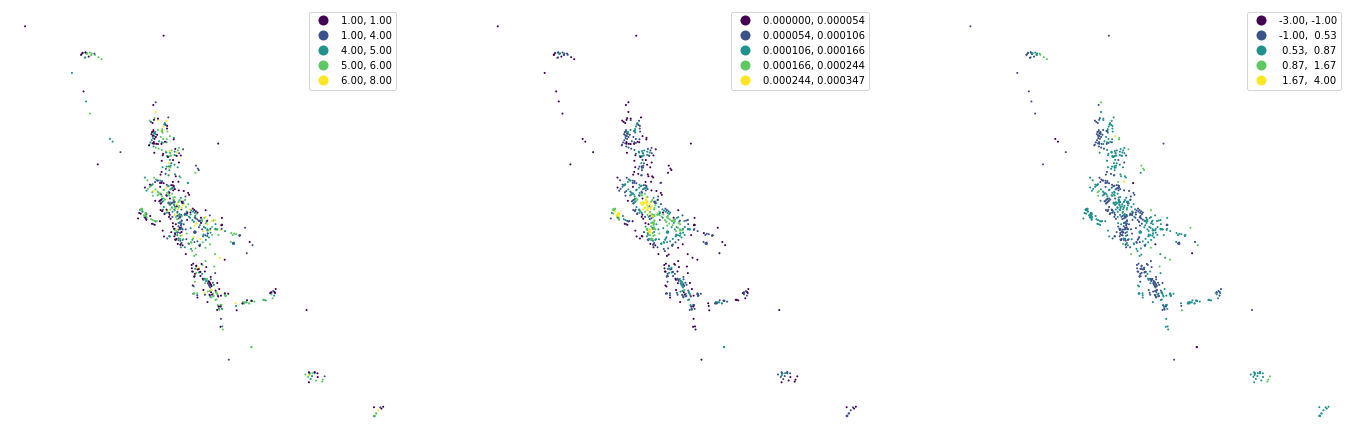

In [30]:
fig, ax = plt.subplots(1, 3, figsize=(24, 12))

nodes.plot("degree", ax=ax[0], scheme="natural_breaks", legend=True, markersize=1)
nodes.plot("closeness", ax=ax[1], scheme="natural_breaks", legend=True, markersize=1, legend_kwds={"fmt": "{:.6f}"})
nodes.plot("meshedness", ax=ax[2], scheme="natural_breaks", legend=True, markersize=1)

ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()

In [31]:
buildings["nodeID"] = momepy.get_node_id(buildings, nodes, streets, "nodeID", "nID")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 12127/12127 [00:01<00:00, 7006.72it/s]


Link all data together (to tessellation cells or buildings).

In [32]:
tessellation.head()

,uID,geometry,nID,area,convexity,neighbors,covered_area,car
0,5453,"POLYGON ((-637358.313 -1200006.277, -637357.92...",624.0,27736.670898,0.995293,0.003108,41793.250296,0.007476
1,5418,"POLYGON ((-636871.053 -1199819.853, -636871.45...",630.0,19855.193192,0.942935,0.005466,56679.209969,0.022276
2,10635,"POLYGON ((-637462.192 -1199942.387, -637450.89...",624.0,5980.537480,0.900015,0.006719,23484.755027,0.066270
3,5452,"POLYGON ((-636574.691 -1199444.622, -636572.80...",1608.0,18362.214059,0.988620,0.003802,42309.584227,0.005690
4,10641,"POLYGON ((-637599.665 -1199909.097, -637595.79...",624.0,6221.647571,0.829355,0.010157,43342.518118,0.049808


In [33]:
merged = tessellation.merge(buildings.drop(columns=['nID', 'geometry']), on='uID')
merged = merged.merge(streets.drop(columns='geometry'), on='nID', how='left')
merged = merged.merge(nodes.drop(columns='geometry'), on='nodeID', how='left')

In [34]:
merged.columns

Index(['uID', 'geometry', 'nID', 'area_x', 'convexity', 'neighbors',
       'covered_area', 'car', 'area_y', 'eri', 'elongation', 'shared_walls',
       'neighbor_distance', 'interbuilding_distance', 'adjacency', 'nodeID',
       'length', 'linearity', 'width', 'width_deviation', 'openness', 'mm_len',
       'node_start', 'node_end', 'degree', 'closeness', 'meshedness'],
      dtype='object')

## Understanding the context

Measure first, second and third quartile of distribution of values within an area around each building.

In [35]:
percentiles = []
for column in merged.columns.drop(["uID", "nodeID", "nID", 'mm_len', 'node_start', 'node_end', "geometry"]):
    perc = momepy.Percentiles(merged, column, queen_3, "uID", verbose=False).frame
    perc.columns = [f"{column}_" + str(x) for x in perc.columns]
    percentiles.append(perc)

/Users/martin/mambaforge/envs/stable/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1374: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
/Users/martin/mambaforge/envs/stable/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1374: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
/Users/martin/mambaforge/envs/stable/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1374: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
/Users/martin/mambaforge/envs/stable/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1374: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
/Users/martin/mambaforge/envs/stable/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1374: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(
/Users/martin/mambaforge/envs/stable/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1374: RuntimeWarning: All-NaN slice encountered
 

In [36]:
percentiles_joined = pandas.concat(percentiles, axis=1)
percentiles_joined.head()

,area_x_25,area_x_50,area_x_75,convexity_25,convexity_50,convexity_75,neighbors_25,neighbors_50,neighbors_75,covered_area_25,...,openness_75,degree_25,degree_50,degree_75,closeness_25,closeness_50,closeness_75,meshedness_25,meshedness_50,meshedness_75
0,7151.505440,8460.534526,9102.552267,0.874500,0.888902,0.929755,0.006852,0.007068,0.007307,38509.340860,...,0.952261,6.0,6.0,6.0,0.000064,0.000064,0.000064,0.866667,0.866667,0.866667
1,2635.809199,3979.104339,7912.110750,0.906751,0.943435,0.980033,0.012226,0.021552,0.027465,34791.666675,...,1.000000,4.0,6.0,6.0,0.000067,0.000067,0.000075,0.764706,0.866667,1.000000
2,4869.281367,6119.443335,9102.552267,0.874500,0.947803,0.971754,0.007068,0.008105,0.009836,28474.090836,...,0.952261,6.0,6.0,6.0,0.000064,0.000064,0.000064,0.866667,0.866667,0.866667
3,774.500023,2527.511720,9756.635411,0.841715,0.946898,0.979633,0.012229,0.026525,0.032112,10886.683093,...,0.611111,1.0,4.0,7.0,0.000044,0.000056,0.000074,0.666667,0.764706,0.764706
4,5615.435876,6119.443335,8460.534526,0.888902,0.947803,0.971754,0.007598,0.008616,0.009836,27790.702394,...,0.952261,6.0,6.0,6.0,0.000064,0.000064,0.000064,0.866667,0.866667,0.866667


See the difference between original convexity and spatially lagged one.

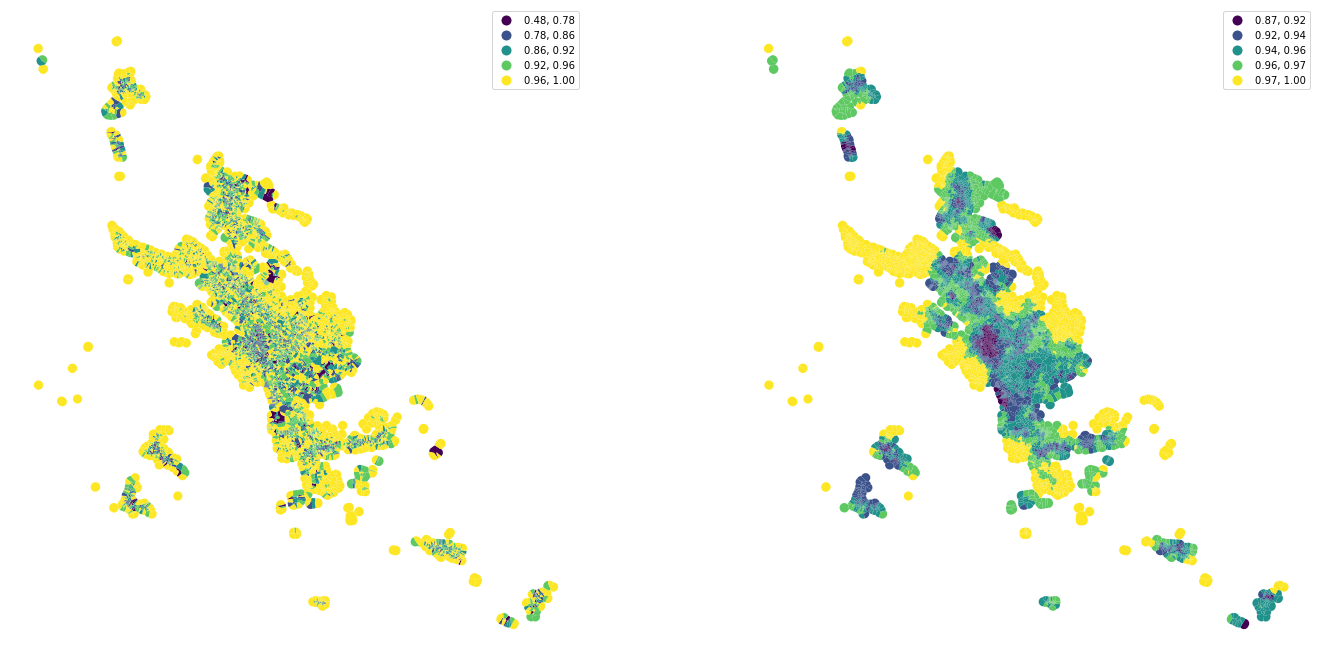

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))

tessellation.plot("convexity", ax=ax[0], scheme="natural_breaks", legend=True)
merged.plot(percentiles_joined['convexity_50'].values, ax=ax[1], scheme="natural_breaks", legend=True)

ax[0].set_axis_off()
ax[1].set_axis_off()

## Clustering

Now we can use obtained values within a cluster analysis that should detect types of urban structure.

Standardize values before clustering.

In [38]:
standardized = (percentiles_joined - percentiles_joined.mean()) / percentiles_joined.std()
standardized.head()

,area_x_25,area_x_50,area_x_75,convexity_25,convexity_50,convexity_75,neighbors_25,neighbors_50,neighbors_75,covered_area_25,...,openness_75,degree_25,degree_50,degree_75,closeness_25,closeness_50,closeness_75,meshedness_25,meshedness_50,meshedness_75
0,3.907232,3.744142,2.446186,-1.143424,-2.938231,-3.733482,-2.119526,-2.288624,-2.285125,4.403142,...,1.545997,1.162460,0.754077,0.390482,-0.160493,-0.376773,-0.569981,1.356558,1.186797,0.666247
1,1.192925,1.449191,2.020484,-0.173765,-0.333045,0.415801,-1.727120,-1.477709,-1.462961,3.880431,...,1.786410,0.123991,0.754077,0.390482,-0.113155,-0.333712,-0.407101,0.962200,1.186797,1.063455
2,2.535427,2.545264,2.446186,-1.143424,-0.124355,-0.267492,-2.103782,-2.230578,-2.181994,2.992171,...,1.545997,1.162460,0.754077,0.390482,-0.160493,-0.376773,-0.569981,1.356558,1.186797,0.666247
3,0.074124,0.705828,2.680086,-2.129171,-0.167582,0.382748,-1.726925,-1.199249,-1.273425,0.519354,...,-0.172044,-1.433713,-0.363338,1.010911,-0.509939,-0.498467,-0.423321,0.583010,0.777269,0.362500
4,2.983927,2.545264,2.216600,-0.710405,-0.124355,-0.267492,-2.065064,-2.201966,-2.181994,2.896085,...,1.545997,1.162460,0.754077,0.390482,-0.160493,-0.376773,-0.569981,1.356558,1.186797,0.666247


### How many clusters?

To determine how many clusters we should aim for, we can use a little package called `clustergram`. See its [documentation](https://clustergram.readthedocs.io) for details.

In [39]:
cgram = Clustergram(range(1, 12), n_init=10, random_state=42)
cgram.fit(standardized.fillna(0))

show(cgram.bokeh())

K=1 skipped. Mean computed from data directly.
K=2 fitted in 0.09209084510803223 seconds.
K=3 fitted in 0.17666196823120117 seconds.
K=4 fitted in 0.1387166976928711 seconds.
K=5 fitted in 0.1958770751953125 seconds.
K=6 fitted in 0.2466108798980713 seconds.
K=7 fitted in 0.25217103958129883 seconds.
K=8 fitted in 0.23486900329589844 seconds.
K=9 fitted in 0.2962191104888916 seconds.
K=10 fitted in 0.39074087142944336 seconds.
K=11 fitted in 0.3091151714324951 seconds.


/Users/martin/mambaforge/envs/stable/lib/python3.9/site-packages/bokeh/io/notebook.py:487: DeprecationWarning: The `source` parameter emit a  deprecation warning since IPython 8.0, it had no effects for a long time and will  be removed in future versions.
  publish_display_data(data, metadata, source, transient=transient, **kwargs)


Clustegram gives us also the final labels. (Normally, you would run the final clustering on much larger number of initialisations.)

In [40]:
cgram.labels.head()

,1,2,3,4,5,6,7,8,9,10,11
0,0,1,2,3,3,1,5,0,6,6,5
1,0,1,2,3,3,1,5,0,6,6,5
2,0,1,2,3,3,1,5,0,6,6,5
3,0,1,1,1,2,2,1,4,2,2,10
4,0,1,2,3,3,1,5,0,6,6,5


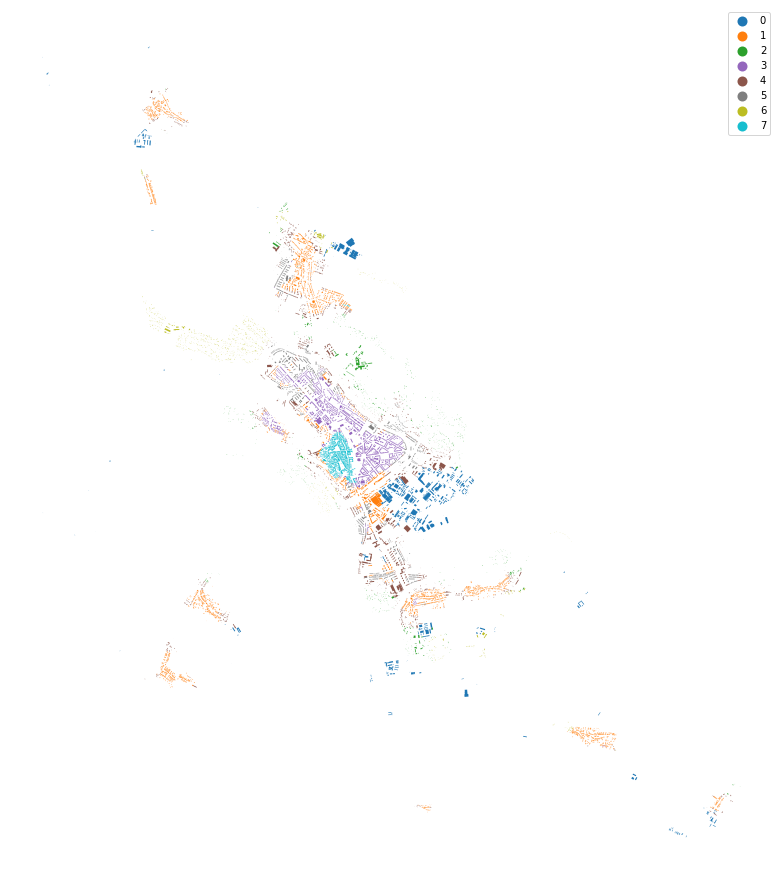

In [41]:
merged["cluster"] = cgram.labels[8].values
urban_types = buildings[["geometry", "uID"]].merge(merged[["uID", "cluster"]], on="uID")
urban_types.plot("cluster", categorical=True, figsize=(16, 16), legend=True).set_axis_off()

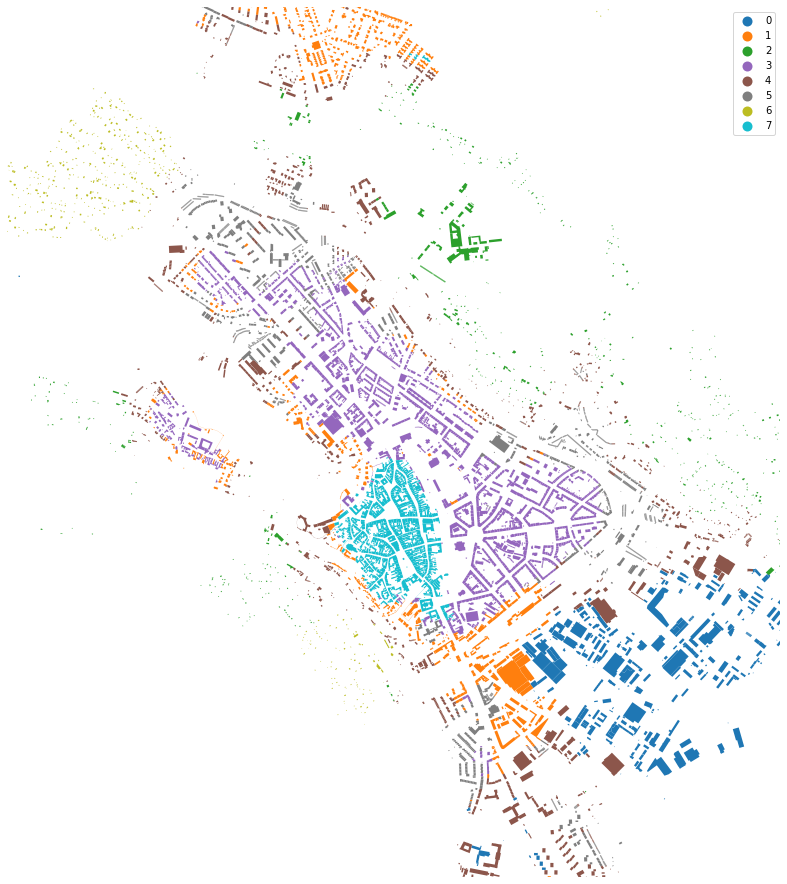

In [46]:
ax = urban_types.plot("cluster", categorical=True, figsize=(16, 16), legend=True)
ax.set_xlim(-645000, -641000)
ax.set_ylim(-1195500, -1191000)
ax.set_axis_off()